In [3]:
import argparse
import os
import sys

import pandas as pd
import seaborn as sns

sys.path.insert(0, "..")

from powerful_benchmarker.utils.constants import add_default_args
from validator_tests.eval_validators import (
    _get_best_accuracy_per_adapter,
    _get_correlation,
    group_by_task_validator,
)
from validator_tests.utils import create_main
from validator_tests.utils.constants import TARGET_ACCURACY, add_exp_group_args
from validator_tests.utils.df_utils import get_name_from_df, unify_validator_columns
from validator_tests.utils.plot_val_vs_acc import scatter_plot

In [4]:
def get_folder_name(folder, full_df):
    return os.path.join(folder, get_name_from_df(full_df, assert_one_task=True))


def save_boxplot(folder_name, df, x, y, filename, figsize=(4.8, 4.8)):
    sns.set(style="whitegrid", rc={"figure.figsize": figsize})
    plot = sns.boxplot(data=df, x=x, y=y)
    fig = plot.get_figure()
    fig.savefig(
        os.path.join(folder_name, f"{filename}.png"),
        bbox_inches="tight",
    )
    fig.clf()


def plot_globally_ranked(folder_name, one_adapter, x_name, adapter_name):
    groupby = group_by_task_validator(per_adapter=True)
    ranks = one_adapter.groupby(groupby)["score"].rank(method="min", ascending=False)
    one_adapter["rank"] = ranks
    scatter_plot(
        folder_name,
        df=one_adapter,
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_all",
        c="rank",
        figsize=(4.8, 4.8),
    )
    scatter_plot(
        folder_name,
        df=one_adapter[one_adapter["rank"] < 200],
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_top200",
        figsize=(4.8, 4.8),
        s=1,
    )
    return one_adapter


def plot_trial_ranked(folder_name, one_adapter, x_name, adapter_name):
    one_adapter = _get_best_accuracy_per_adapter(
        one_adapter, nlargest=100, rank_by="score", return_ranks=True
    )
    scatter_plot(
        folder_name,
        df=one_adapter,
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_per_trial",
        c="rank",
        figsize=(4.8, 4.8),
        s=1,
    )
    scatter_plot(
        folder_name,
        df=one_adapter[one_adapter["rank"] < 5],
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_per_trial_top5",
        figsize=(4.8, 4.8),
        s=1,
    )
    return one_adapter


def plot_best_pairs(folder_name, df):
    df = unify_validator_columns(
        df, new_col_name="unified_validator", drop_validator_args=False
    )
    best_validators = [
        (
            x,
            "BNMSummedSrcVal_layer_logits"
            if x == "ATDOCConfig"
            else "Accuracy_average_micro_split_src_val",
        )
        for x in adapter_names()
    ]
    mask = False
    for adapter, validator in best_validators:
        mask |= (df["adapter"] == adapter) & (df["unified_validator"] == validator)
    df = df[mask]
    gdf = plot_globally_ranked(folder_name, df, "adapter", "ALL")
    tdf = plot_trial_ranked(folder_name, df, "adapter", "ALL")
    gdf = gdf.sort_values(by=["adapter"])
    tdf = tdf.sort_values(by=["adapter"])

    save_boxplot(
        folder_name,
        gdf[gdf["rank"] < 200],
        "adapter",
        TARGET_ACCURACY,
        "AAA_best_pairs_global_boxplot",
    )
    save_boxplot(
        folder_name,
        tdf[tdf["rank"] < 5],
        "adapter",
        TARGET_ACCURACY,
        "AAA_best_pairs_per_trial_boxplot",
    )


def adapter_names():
    return [
        "ATDOCConfig",
        "BNMConfig",
        "BSPConfig",
        "CDANConfig",
        "DANNConfig",
        "GVBConfig",
        "IMConfig",
        "MCCConfig",
        "MCDConfig",
        "MMDConfig",
    ]

In [28]:
df1 = pd.read_pickle()
df2 = pd.read_pickle()
df = pd.concat([df1, df2], axis=0)

In [29]:
# corr_name = "weighted_spearman"
# corr = _get_correlation(df.copy(), True, 0.0, corr_name)
# corr = pd.melt(
#             corr,
#             id_vars=["validator", "validator_args", "task"],
#             value_vars=adapter_names(),
#             var_name="adapter",
#             value_name=corr_name,
#         )
# assert len(corr["task"].unique()) == 1
# corr = corr.merge(df)
corr = df.copy()
corr = unify_validator_columns(
    corr, new_col_name="unified_validator", drop_validator_args=False
)
best_validators = [
    (
        x,
        "BNMSummedSrcVal_layer_logits"
        if x == "ATDOCConfig"
        else "Accuracy_average_micro_split_src_val",
    )
    for x in adapter_names()
]
mask = False
for adapter, validator in best_validators:
    mask |= (corr["adapter"] == adapter) & (corr["unified_validator"] == validator)
corr = corr[mask]

In [30]:
best_per_adapter = _get_best_accuracy_per_adapter(corr, nlargest=100, rank_by="score", return_ranks=True)

            score  trial_num epoch
1146691  0.804527         38    70
1037850  0.804527         88    60
992326   0.806584         35   140
1038429  0.812757         85   140
1019847  0.804527         97    50
1039573  0.814815         61   120


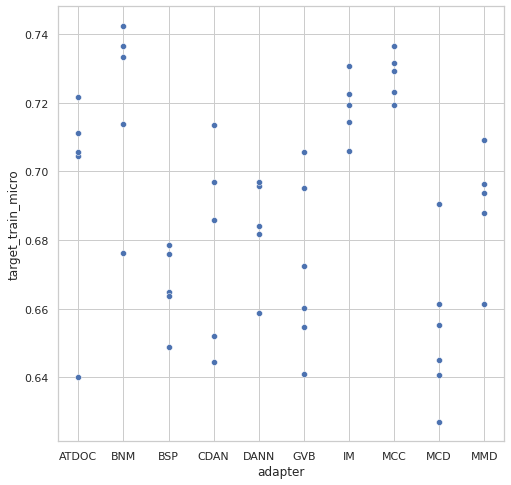

In [38]:
to_plot = best_per_adapter[best_per_adapter["rank"] <= 5]
to_plot = to_plot.sort_values(by=["adapter"])
to_plot["adapter"] = to_plot["adapter"].str.replace("Config", "")
print(to_plot[to_plot["adapter"]=="GVB"][["score", "trial_num", "epoch"]])

sns.set(style="whitegrid", rc={"figure.figsize": (8, 8)})
plot = sns.scatterplot(data=to_plot, x="adapter", y=TARGET_ACCURACY)